# Data preparation

## Model Input / Output structure

### Time Dimension

Do I have to use time from `datetime` or `local_solar_time` as time?

- `local_solar_time` intervals are 10 minutes
- `datetime` intervals are 30 minutes
- real time dimension is `datetime`

The `local_solar_time` works as one more feature. It is like one more coordinate for the density measurement.

I assume the `density` measurements are done on `datetime` time scale.
So, I'll use `datetime` for sampling.


### Input

It is a time series.

- Each element of this time series is a matrix on the time dimension, i.e.:
  data_set: Sample(t_0), Sample(t_1),..., Sample(t_n),..., Sample(t_max)
  where t_x is the `datetime` value (or just an index. See below.).
- Since all time intervals (t_delta) between samples are the same (30 min) and no samples are missing, I can use a Sequence with int indexing to access the individual samples. No need to use the `datetime` as index.
- Because time is an important feature for density, I could use a year, a numerical day [0, 364/365], and an hour [0, 23] as additional features. TODO Evaluate this hypothesis.
- I have 48 samples per file. 
- A sample presented by (19 * 73 * 137)=190019 rows, by the `density` value.
- Files with len != 190019*48 rows are removed from training and evaluation.

#### Input reduction

I have a "stable" file structure. That means:
- all files with a stable number of rows (9120912) have a stable structure.
- all elements in these fields, ['datetime' (time part of it), 'latitude',	'longitude', 'altitude', 'local_solar_time'] are equal (in values and positions) in all "stable" files.

That means I could use rows and fields of the existing "stable" files without sorting.
I can use only `density` filed in the Input/Output Samples for training and inference. Restoring other fields of the Samples can be simply done.
Since removing other fields from file does not reduce the file size (because of the `parquet` effective compression), I do not remove other files from files.

- I reduce the input size and the snapshot dimension for faster training of the baseline model to the 'snapshot_size' value.

### Output

- Output is a vector of 'snapshot_size' predicted density values, the `density_predicted`.

### Autoregressive cycle

It is executed after model inferences/predicts the Output.

- Sample(t_max+1):
  - Sample(t_max+1) = Sample(t_max)
  - for row in sample_rows [Optional. It is needed only to present the predicted data.]:
      - `hour` is incremented by t_delta
      - if `hour` == `hours_in_day`: # day increase
        - `day` += 1
        - `hour` = 0
      - latitude, longitude, altitude, local_solar_time copied from Sample(t_max)
      - `density` = `density_predicted`


In [1]:
import os
from pathlib import Path
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from sklearn.preprocessing import MinMaxScaler


In [3]:
SAMPLE_SIZE = 10000
SAMPLES_IN_FILE = 48
ROWS_IN_FILE = SAMPLE_SIZE * SAMPLES_IN_FILE

INPUT_DIR = '../data/reduced/2000'
INPUT_FILE_PATTERN = '2000-*.parquet'
DATA_FIELDS = ['datetime', 'density']

## Data preprocessing v2. TODO

In [4]:
def load_data_from_parquet(parquet_files, verbose=False):
    """load and preprocess data from Parquet files."""
    data_frames = []
    for file in parquet_files:
        df = pd.read_parquet(file, columns=DATA_FIELDS)
        if verbose:
            print(f"  Loaded {file} {df.shape}")
        else:
            print('.', end='')
        data_frames.append(df)
    combined_df = pd.concat(data_frames).reset_index(drop=True)
    return combined_df

def create_sequences(data, seq_length):
    """Create input sequences and their respective targets (shifted by one step)."""
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        target = data[i + seq_length]  # The next time step
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def get_dataloader(sequence_length=SAMPLES_IN_FILE, batch_size=32, tensor_dtype=torch.float32, verbose=False, files=None, train_split=0.8):
    # Load the data from files
    parquet_files = glob.glob(f"{INPUT_DIR}/{INPUT_FILE_PATTERN}")[:files]
    data = load_data_from_parquet(parquet_files)
    print(f"Loaded {len(parquet_files)} files, {data.shape}")
    
    # Extracting 'density' values as input samples, and creating shifted targets
    density_values = data['density'].values.reshape(-1, SAMPLE_SIZE)  # Reshape into (n_samples, SAMPLE_SIZE)
    if verbose:
        print(f"  {density_values.shape=}")
    
    # Normalize the density values
    scaler = MinMaxScaler()
    density_normalized = scaler.fit_transform(density_values)
    print(f"Normalized {len(density_normalized) = }, {density_normalized[0] = }")
    
    sequences, targets = create_sequences(density_normalized, sequence_length)
    
    # Convert to PyTorch tensors
    sequences = torch.tensor(sequences, dtype=tensor_dtype)
    targets = torch.tensor(targets, dtype=tensor_dtype)
    if verbose:
        print(f"  {sequences.shape=}")
        print(f"  {targets.shape=}")

    # Split data into training and validation sets (80% train, 20% validation)
    train_size = int(train_split * len(sequences))
    val_size = len(sequences) - train_size
    train_dataset, val_dataset = random_split(TensorDataset(sequences, targets), [train_size, val_size])
    print(f"Created TensorDatasets: {train_dataset=}, {val_dataset=}")
    
    # Create DataLoaders without shuffling
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    print(f"Created DataLoaders: {train_loader=}, {val_loader=}, {batch_size=}")
    return train_loader, val_loader, density_normalized, scaler


In [5]:
# Sanity check:

train_loader, val_loader, density_normalized, scaler = get_dataloader(sequence_length=3, batch_size=4, tensor_dtype=torch.float32, verbose=False, files=50)
print(f"{len(train_loader) = }, {len(val_loader) = }")

for i, (sequences_batch, targets_batch) in enumerate(train_loader):
    print(i)
    print(f" {sequences_batch.shape =}")
    print(f" {targets_batch.shape =}")
    break

..................................................Loaded 50 files, (12000000, 2)
Normalized len(density_normalized) = 1200, density_normalized[0] = array([1.0058001e-08, 5.5147993e-09, 3.2282998e-09, ..., 2.8465999e-12,
       2.6720000e-12, 2.5087001e-12], dtype=float32)
Created TensorDatasets: train_dataset=<torch.utils.data.dataset.Subset object at 0x74fee9d1efb0>, val_dataset=<torch.utils.data.dataset.Subset object at 0x74fee9d1f520>
Created DataLoaders: train_loader=<torch.utils.data.dataloader.DataLoader object at 0x74fee9d1e950>, val_loader=<torch.utils.data.dataloader.DataLoader object at 0x74fee9d1ece0>, batch_size=4
len(train_loader) = 240, len(val_loader) = 60
0
 sequences_batch.shape =torch.Size([4, 3, 10000])
 targets_batch.shape =torch.Size([4, 10000])


## Data preprocessing v1 TODO

In [35]:
def _load_file(file_path, verbose=False):
    """
    Load a file and convert all values to a numeric type.
    """
    df = pd.read_parquet(file_path, columns=['datetime', 'density'])
    assert df.shape[0] == ROWS_IN_FILE, f"File {file_path}, {df.shape[0]} != 9120912"
    if verbose:
        print(f"Loaded {df.shape} {file_path}")
    else:
        print('.', end='')
    return df

    
class PandasDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths  # List of paths to pandas files
        self.transform = transform
        self.data = None  # Placeholder for loaded data

    
    def load_file(self, idx):
        """Load the pandas file at the given index."""
        file_path = self.file_paths[idx]
        self.data = _load_file(file_path)
        # print(self.data.tail())
        if self.transform:
            self.data = self.transform(self.data)

    def __len__(self):
        """Total number of rows across all files."""
        # total_length = 0
        # for file in self.file_paths:
        #     total_length += len(_load_file(file))  # Adjust based on file format
        # return total_length
        return 9120912 * len(self.file_paths) # Rows in file should always be 9120912 !

    def __getitem__(self, idx):
        """Return a single sample from the dataset."""
        # Identify which file the idx belongs to
        file_idx = 0
        while idx >= SAMPLES_IN_FILE: # It should be always 48 ! # len(_load_file(self.file_paths[file_idx])):
            idx -= SAMPLES_IN_FILE # len(_load_file(self.file_paths[file_idx]))
            file_idx += 1
        
        # Load the relevant file and fetch the row
        if self.data is None or self.current_file_idx != file_idx:
            self.load_file(file_idx)
            self.current_file_idx = file_idx

        row = self.data.iloc[idx]

        # convert pandas row to tensor
        features = torch.tensor(row.iloc[:-1].values, dtype=torch.float32)  # Example for feature extraction
        label = torch.tensor(row.iloc[-1], dtype=torch.float32)  # Example for label

        return features, label

# Paths to your pandas files
# file_name = '2000-01-01.e744a8ed50e64f5b8f56d3bab9f2cd1d-0.parquet'
# file_path = Path('../data/original/2000') / file_name
# file_paths = [file_path]

data_dir = '../data'
original_data_dir = 'original'
year = '2000'
directory = Path(data_dir) / original_data_dir  / str(year)
file_names = os.listdir(directory)[:10]  # DEBUG
print(f'{len(file_names) = }')
# files should be sorted!
file_paths = [Path(data_dir) / original_data_dir  / str(year) / file_name for file_name in sorted(file_names)]
file_paths = [pth for pth in file_paths if len(_load_file(pth)) == ROWS_IN_FILE]
print(f'{len(file_paths) = }')
                       
file_paths = file_paths[:2] # DEBUG
print(f'{len(file_paths) = }')

# Create the Dataset

dataset = PandasDataset(file_paths)
num_epochs = 2
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Example usage in training loop
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for batch in dataloader:
        inputs, labels = batch
        print(inputs.shape)
        print(labels.shape)
        break
    break
        # Train your model with inputs and labels


len(file_names) = 366
..........len(file_paths) = 10
len(file_paths) = 2
Epoch: 0
.torch.Size([32, 6])
torch.Size([32])


# Model

## Transformer

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :]

class TransformerTimeSeries(nn.Module):
    def __init__(self, num_features, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048):
        super(TransformerTimeSeries, self).__init__()
        self.input_layer = nn.Linear(num_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(d_model, num_features)  # Output same dimension as input (10 features)

    def forward(self, src):
        src = self.input_layer(src)
        src = self.pos_encoder(src)
        transformer_output = self.transformer_encoder(src)
        output = self.fc(transformer_output[:, -1, :])  # Use the last time step output
        return output

## Train

In [7]:
files = 50
num_epochs = 10
num_features = SAMPLE_SIZE  # Each 'datetime' has a vector of SAMPLE_SIZE 'density' values
sequence_length = 3
batch_size = 4
lr = 0.001

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
early_stop_counter = 0

# Store loss values for visualization
train_loss_history = []
val_loss_history = []

train_loader, val_loader, density_normalized, scaler = get_dataloader(sequence_length=sequence_length, batch_size=batch_size, tensor_dtype=torch.float32, verbose=False, files=files)


# Initialize model, optimizer, and loss function
model = TransformerTimeSeries(num_features=num_features)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        sequences_batch, targets_batch = batch
        
        # Forward pass
        optimizer.zero_grad()
        predictions = model(sequences_batch)
        
        # Compute loss
        loss = criterion(predictions, targets_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            sequences_batch, targets_batch = batch
            predictions = model(sequences_batch)
            loss = criterion(predictions, targets_batch)
            val_loss += loss.item()

    # Calculate average validation loss for this epoch
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    
    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0  # Reset the counter if validation loss improves
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.7f}, Val Loss: {avg_val_loss:.7f} (Improved)")
    else:
        early_stop_counter += 1
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.7f}, Val Loss: {avg_val_loss:.7f}")
    
    # Stop training if no improvement is seen for 'patience' number of epochs
    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. No improvement for {patience} epochs.")
        break


..................................................Loaded 50 files, (12000000, 2)
Normalized len(density_normalized) = 1200, density_normalized[0] = array([1.0058001e-08, 5.5147993e-09, 3.2282998e-09, ..., 2.8465999e-12,
       2.6720000e-12, 2.5087001e-12], dtype=float32)
Created TensorDatasets: train_dataset=<torch.utils.data.dataset.Subset object at 0x74fee9dce4d0>, val_dataset=<torch.utils.data.dataset.Subset object at 0x74fee91ec2e0>
Created DataLoaders: train_loader=<torch.utils.data.dataloader.DataLoader object at 0x74fee9c03e50>, val_loader=<torch.utils.data.dataloader.DataLoader object at 0x74fee9179a80>, batch_size=4


/home/leo/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 0.0157920, Val Loss: 0.0019900 (Improved)
Epoch [2/10], Train Loss: 0.0026547, Val Loss: 0.0004402 (Improved)
Epoch [3/10], Train Loss: 0.0004046, Val Loss: 0.0000653 (Improved)
Epoch [4/10], Train Loss: 0.0000971, Val Loss: 0.0000422 (Improved)
Epoch [5/10], Train Loss: 0.0000477, Val Loss: 0.0000186 (Improved)
Epoch [6/10], Train Loss: 0.0000271, Val Loss: 0.0000117 (Improved)
Epoch [7/10], Train Loss: 0.0000157, Val Loss: 0.0000092 (Improved)
Epoch [8/10], Train Loss: 0.0000118, Val Loss: 0.0000046 (Improved)
Epoch [9/10], Train Loss: 0.0000078, Val Loss: 0.0000053
Epoch [10/10], Train Loss: 0.0000064, Val Loss: 0.0000044 (Improved)


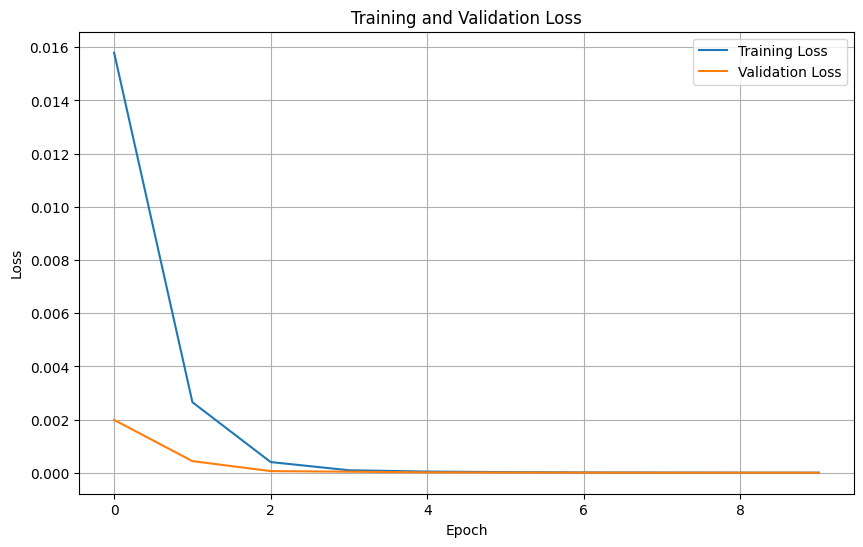

In [8]:
# Plotting the loss history
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Inference (predicting the next density vector from the last available sequence)
sequence_length = 3

model.eval()
with torch.no_grad():
    last_sequence = torch.tensor(density_normalized[-sequence_length:], dtype=torch.float32).unsqueeze(0)
    prediction = model(last_sequence)
    prediction = scaler.inverse_transform(prediction.numpy())  # Inverse transform to original scale
    print("Next predicted density vector:", prediction)

Next predicted density vector: [[ 1.6741596e-05  1.7674180e-03  2.1249938e-03 ... -1.9194558e-03
   1.0142568e-03 -5.0163362e-05]]
